In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Stemmer mencari kata dasar
factory = StemmerFactory()
stemmer = factory.create_stemmer()

print("Stemmer Sastrawi = Siap")

Stemmer Sastrawi = Siap


In [ ]:
# Slang
kamus_slang = {
    'yg': 'yang', 'gk': 'tidak', 'gak': 'tidak', 'ga': 'tidak', 'engga': 'tidak',
    'bgt': 'banget', 'bngtt': 'banget', 'tpi': 'tapi', 'tp': 'tapi',
    'brg': 'barang', 'sy': 'saya', 'aku': 'saya', 'sdh': 'sudah',
    'blm': 'belum', 'dgn': 'dengan', 'thx': 'terima kasih',
    'sampe': 'sampai', 'nyampe': 'sampai', 'ok': 'oke',
    'nyesel': 'sesal', 'menyesal': 'sesal',
    'good': 'bagus', 'best': 'bagus', 'bad': 'buruk'
}

# Fungsi penanganan negasi otomatis menggabung "tidak_rusak"
def handle_negation(text):
    words = text.split()
    new_words = []
    penidak = ['tidak', 'bukan', 'jangan', 'belum']

    skip = False
    for i in range(len(words)):
        if skip:
            skip = False
            continue

        # jika ketemu kata penidak dan ada kata setelahnya
        if words[i] in penidak and i + 1 < len(words):
            word_next = words[i+1]
            # nanti akan digabungkan jadi satu kata dengan underscore
            new_words.append(f"{words[i]}_{word_next}")
            skip = True
        else:
            new_words.append(words[i])

    return ' '.join(new_words)

# fungsi pembersihan
def bersihkan_teks(text):
    # huruf kecil
    text = str(text).lower()

    # hapus angka dan tanda baca
    text = re.sub(r'[^a-z\s]', ' ', text)

    # normalisasi Slang
    words = text.split()
    words = [kamus_slang[w] if w in kamus_slang else w for w in words]
    text = ' '.join(words)

    # stemming sastrawi
    text = stemmer.stem(text)

    # handle negation
    # Supaya "tidak nyesel" -> "tidak sesal" -> "tidak_sesal"
    text = handle_negation(text)

    return text

print("Fungsi pembersihan = Siap")

Fungsi pembersihan = Siap


In [ ]:
# load data
try:
    df = pd.read_csv('reviews.csv')
    # kolom label (1=Positif, 0=Negatif)
    df['sentimen'] = df['label'].apply(lambda x: 'Positif' if x==1.0 else 'Negatif')
except:
    print("File tidak ada, upload dahulu")

# pembersihan
print("Sedang memproses teks dengan Sastrawi")
df['text_clean'] = df['reviews'].apply(bersihkan_teks)

print("Selesai")
print(df[['reviews', 'text_clean', 'sentimen']].head())

Sedang memproses teks dengan Sastrawi
Selesai
                                             reviews  \
0  kemeja nya bagusss bgtttt😍😍😍aaaa mauuu nngisss...   
1  Jahitannya sih rapi,cuman ada benang yang ikut...   
2  Sesuai harga. Agak tipis tapi masih oke kok. W...   
3  Wah gila sihhh sebagus itu, se worth it, se  l...   
4  Kain nya bagus halus  \nTapi kok di bukak koto...   

                                          text_clean sentimen  
0  kemeja nya bagusss bgtttt aaaa mauuu nngisssss...  Positif  
1  jahit sih rapi cuman ada benang yang ikut ke j...  Negatif  
2  sesuai harga agak tipis tapi masih oke kok war...  Negatif  
3  wah gila sihhh bagus itu se worth it se lembut...  Positif  
4  kain nya bagus halus tapi kok di bukak kotor y...  Negatif  


In [ ]:
# "sesal" = negatif
# "tidak_sesal" = positif.

data_tambahan = {
    'text_clean': [
        # Kasus Negatif (Sesal)
        'sesal beli sini barang rusak', 'sangat sesal kecewa berat',
        'barang jelek sesal banget', 'parah tidak mau beli lagi sesal',
        'rusak parah hancur lebur', 'toko tipu barang sampah',
        'kecewa barang tidak sesuai', 'kirim lama barang cacat',
        'jangan beli sini rugi', 'kualitas buruk sekali',
        # Negasi Otomatis
        'tidak_sesal beli sini', 'tidak_sesal barang bagus',
        'tidak_sesal beli dua', 'tidak_sesal muas',
        'barang tidak_rusak', 'sampai aman tidak_rusak',
        'packing aman tidak_rusak', 'barang mulus tidak_rusak'
    ],
    'sentimen': [
        'Negatif', 'Negatif', 'Negatif', 'Negatif', 'Negatif',
        'Negatif', 'Negatif', 'Negatif', 'Negatif', 'Negatif',
        'Positif', 'Positif', 'Positif', 'Positif',
        'Positif', 'Positif', 'Positif', 'Positif'
    ]
}

# over sampling agar seimbang (30x)
df_tambahan = pd.DataFrame(data_tambahan)
df_neg = df_tambahan[df_tambahan['sentimen']=='Negatif']
df_pos = df_tambahan[df_tambahan['sentimen']=='Positif']

list_review = (df_neg['text_clean'].tolist() * 30) + (df_pos['text_clean'].tolist() * 30)
list_label = (['Negatif'] * len(df_neg) * 30) + (['Positif'] * len(df_pos) * 30)

df_final_tambahan = pd.DataFrame({'text_clean': list_review, 'sentimen': list_label})
df_gabungan = pd.concat([df[['text_clean', 'sentimen']], df_final_tambahan], ignore_index=True)

print(f"Data latih akhir: {len(df_gabungan)} baris")

Data latih akhir: 1371 baris


Akurasi Model: 93.82%

Laporan klasifikasi:
               precision    recall  f1-score   support

     Negatif       0.91      0.99      0.95       155
     Positif       0.99      0.87      0.92       120

    accuracy                           0.94       275
   macro avg       0.95      0.93      0.94       275
weighted avg       0.94      0.94      0.94       275



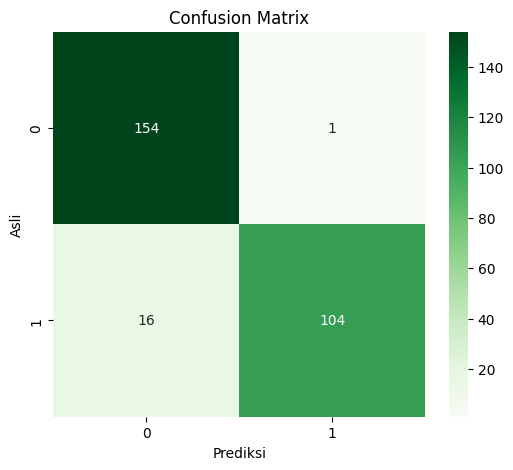

In [ ]:
# pisahkan data
X = df_gabungan['text_clean']
y = df_gabungan['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# vektorisasi (Bigram)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# model Naive Bayes
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# evaluasi
y_pred = model.predict(X_test_vec)
print(f"Akurasi Model: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nLaporan klasifikasi:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.show()

In [ ]:
def prediksi_akhir(kalimat):
    # mebersihkan input user
    input_bersih = bersihkan_teks(kalimat)

    # ubah ke angka
    input_vec = vectorizer.transform([input_bersih])

    # prediksi
    hasil = model.predict(input_vec)[0]
    proba = model.predict_proba(input_vec).max() * 100

    print(f"\n>> Kalimat Asli  : {kalimat}")
    print(f">> Preprocessing : {input_bersih}")
    print(f">> Hasil Prediksi: {hasil} ({proba:.1f}%)")
    print("-" * 40)

print("ketik 'keluar' untuk berhenti.\n")

while True:
    teks = input("Masukkan Ulasan: ")
    if teks.lower() == 'keluar':
        break
    if teks.strip():
        prediksi_akhir(teks)

ketik 'keluar' untuk berhenti.

Masukkan Ulasan: Barang samapai aman tidak rusak

>> Kalimat Asli  : Barang samapai aman tidak rusak
>> Preprocessing : barang samapai aman tidak_rusak
>> Hasil Prediksi: Positif (99.5%)
----------------------------------------
Masukkan Ulasan: Barang bagus nyesel banget beli disini

>> Kalimat Asli  : Barang bagus nyesel banget beli disini
>> Preprocessing : barang bagus sesal banget beli sini
>> Hasil Prediksi: Negatif (58.2%)
----------------------------------------
Masukkan Ulasan: keluar
